# **House Price Prediction using Machine Learning**

This notebook demonstrates an end-to-end machine learning pipeline to predict house prices based on real estate data scraped from Zameen.com.
The data is specifically related to listed houses in Lahore, and is up
to date (2025)

---

###Goals:
Clean and preprocess raw housing data.

Encode categorical location data using frequency encoding.

Engineer meaningful polynomial features for numeric inputs.

Train and compare multiple regression models including CatBoost, XGBoost, Random Forest, and LightGBM.

Tune a state-of-the-art LightGBM regression model using GridSearchCV.

Evaluate model performance with robust metrics: MAE, RMSE, R² Score.

Visualize feature importances to understand predictive drivers.

Save and reuse the trained model for predictions.

Create a prediction function for new, unseen house data using raw input features.


---

### Dataset:
The dataset contains housing listings with attributes such as price, location, bedrooms, bathrooms, and area with varying units.

---

### Tools and Libraries:
Python: Data manipulation and logic

Pandas, NumPy: Data handling

Scikit-learn: Model training, preprocessing, evaluation, and hyperparameter tuning

LightGBM: Fast and efficient gradient boosting for regression

CatBoost, XGBoost, RandomForest: For comparison

Matplotlib & Seaborn: Visualization of feature importance

Joblib / Pickle : for saving


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
file_path = "/content/zameen_houses.csv"
df = pd.read_csv(file_path)

print("Shape of dataset:", df.shape)
print("\nColumn names:", df.columns.tolist())
df.info()
df.head()

Shape of dataset: (1350, 6)

Column names: ['Title', 'Price', 'Location', 'Bedrooms', 'Bathrooms', 'Area']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      1249 non-null   object 
 1   Price      1250 non-null   object 
 2   Location   1250 non-null   object 
 3   Bedrooms   1233 non-null   float64
 4   Bathrooms  1230 non-null   float64
 5   Area       1350 non-null   object 
dtypes: float64(2), object(4)
memory usage: 63.4+ KB


,Title,Price,Location,Bedrooms,Bathrooms,Area
0,10 Marla House For Sale In Gulbahar Block Bahr...,3.2 Crore,"Bahria Town - Gulbahar Block, Bahria Town - Se...",5.0,6.0,10 Marla
1,5 Marla House For Sale In AA Block Bahria Town...,1.8 Crore,"Bahria Town - Block AA, Bahria Town - Sector D",3.0,4.0,5 Marla
2,NaN,NaN,NaN,NaN,NaN,Farm Houses85.6 Lakh - 1.71 Crore1.6 Kanal - 3...
3,Elegance Meets Functionality 1-Kanal Spanish T...,14.9 Crore,"DHA Phase 6 - Block C, DHA Phase 6",8.0,7.0,1 Kanal
4,Stunning 1-Kanal Designer Bungalow with Fully ...,12.99 Crore,"DHA Phase 6 - Block B, DHA Phase 6",6.0,7.0,1 Kanal


In [38]:
df = df.dropna(subset=["Price", "Location", "Bedrooms", "Bathrooms"], how="any").reset_index(drop=True)

In [39]:
df.head()

,Title,Price,Location,Bedrooms,Bathrooms,Area
0,10 Marla House For Sale In Gulbahar Block Bahr...,3.2 Crore,"Bahria Town - Gulbahar Block, Bahria Town - Se...",5.0,6.0,10 Marla
1,5 Marla House For Sale In AA Block Bahria Town...,1.8 Crore,"Bahria Town - Block AA, Bahria Town - Sector D",3.0,4.0,5 Marla
2,Elegance Meets Functionality 1-Kanal Spanish T...,14.9 Crore,"DHA Phase 6 - Block C, DHA Phase 6",8.0,7.0,1 Kanal
3,Stunning 1-Kanal Designer Bungalow with Fully ...,12.99 Crore,"DHA Phase 6 - Block B, DHA Phase 6",6.0,7.0,1 Kanal
4,Brand New 13-Marla Corner House Facing Park | ...,7 Crore,"DHA Phase 4, DHA Defence",5.0,6.0,13 Marla


In [40]:
def convert_price(price_str):
    try:
        if 'Crore' in price_str:
            return float(price_str.replace('Crore', '').strip()) * 1e7
        elif 'Lakh' in price_str:
            return float(price_str.replace('Lakh', '').strip()) * 1e5
        else:
            return np.nan
    except:
        return np.nan

df["Price_PKR"] = df["Price"].apply(convert_price)

df[["Price", "Price_PKR"]].head()

,Price,Price_PKR
0,3.2 Crore,32000000.0
1,1.8 Crore,18000000.0
2,14.9 Crore,149000000.0
3,12.99 Crore,129900000.0
4,7 Crore,70000000.0


In [41]:
def convert_area(area_str):
    try:
        area_str = area_str.strip()
        if 'Marla' in area_str:
            return float(area_str.replace('Marla', '').strip())
        elif 'Kanal' in area_str:
            return float(area_str.replace('Kanal', '').strip()) * 20
        else:
            return np.nan
    except:
        return np.nan

df['Area_Marla'] = df['Area'].apply(convert_area)

df[['Area', 'Area_Marla']].head()


,Area,Area_Marla
0,10 Marla,10.0
1,5 Marla,5.0
2,1 Kanal,20.0
3,1 Kanal,20.0
4,13 Marla,13.0


In [42]:
missing_values = df[['Bedrooms', 'Bathrooms']].isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Bedrooms     0
Bathrooms    0
dtype: int64


In [43]:
print("\nBedrooms distribution:\n", df['Bedrooms'].value_counts().sort_index())
print("\nBathrooms distribution:\n", df['Bathrooms'].value_counts().sort_index())


Bedrooms distribution:
 Bedrooms
1.0      2
2.0     15
3.0    291
4.0    259
5.0    480
6.0    135
7.0     33
8.0      9
9.0      2
Name: count, dtype: int64

Bathrooms distribution:
 Bathrooms
1.0      1
2.0     12
3.0     70
4.0    299
5.0    215
6.0    492
7.0    136
8.0      1
Name: count, dtype: int64


In [44]:
df['Primary_Location'] = df['Location'].apply(lambda x: x.split(',')[0].strip())

df['Primary_Location'].value_counts().head(10)


,count
Primary_Location,
DHA Phase 6,86
DHA Phase 7,83
Park View City,78
DHA 9 Town,56
DHA Phase 5,43
Central Park Housing Scheme,32
DHA 11 Rahbar Phase 2,24
DHA Phase 8,20
DHA Phase 4,17



=== Area (Marla) Statistics ===
count    1226.000000
mean       13.330424
std        11.364785
min         1.000000
25%         5.000000
50%        10.000000
75%        20.000000
max       102.000000
Name: Area_Marla, dtype: float64


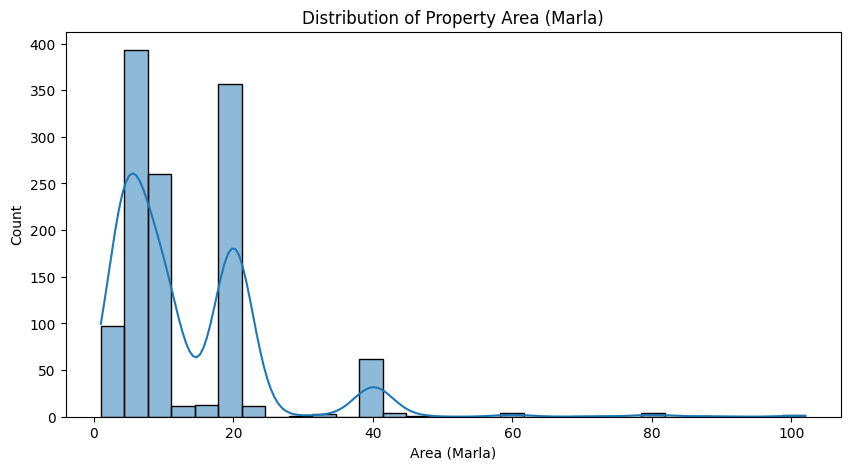

In [45]:
print("\n=== Area (Marla) Statistics ===")
print(df['Area_Marla'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['Area_Marla'], bins=30, kde=True)
plt.title('Distribution of Property Area (Marla)')
plt.xlabel('Area (Marla)')
plt.ylabel('Count')
plt.show()

Observations:

The dataset has 1226 valid properties with area data.

Average property size is about 13.3 Marla.

Property sizes vary a lot (std dev ~11.36), ranging from very small (1 Marla) to very large (102 Marla).

Half of the properties have an area between 5 Marla (25th percentile) and 20 Marla (75th percentile).

Median is 10 Marla, meaning half the properties are smaller than 10 Marla and half are bigger.


=== Price by Number of Bedrooms ===
                  mean       median          min          max  count
Bedrooms                                                            
1.0       4.195000e+07   41950000.0   13900000.0   70000000.0      2
2.0       1.194600e+07    9000000.0    4000000.0   25000000.0     15
3.0       2.058933e+07   20500000.0    5500000.0   67000000.0    291
4.0       3.265483e+07   23500000.0    7800000.0  260000000.0    259
5.0       7.455458e+07   71500000.0    8000000.0  600000000.0    480
6.0       1.570963e+08  102500000.0   19500000.0  750000000.0    135
7.0       1.762697e+08   85000000.0   24000000.0  950000000.0     33
8.0       2.355556e+08  152500000.0  120000000.0  580000000.0      9
9.0       1.350000e+08  135000000.0  120000000.0  150000000.0      2


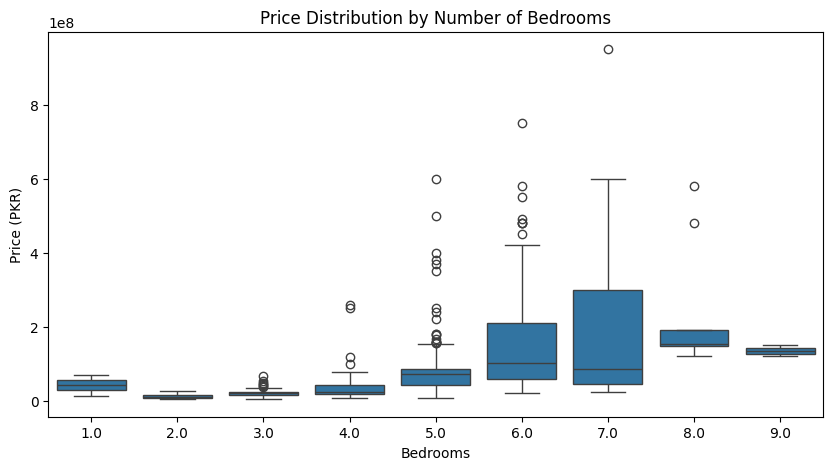

In [46]:
price_by_bedrooms = df.groupby('Bedrooms')['Price_PKR'].agg(['mean', 'median', 'min', 'max', 'count'])
print("\n=== Price by Number of Bedrooms ===")
print(price_by_bedrooms)

plt.figure(figsize=(10, 5))
sns.boxplot(x='Bedrooms', y='Price_PKR', data=df)
plt.title('Price Distribution by Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price (PKR)')
plt.show()

Observations:

Price tends to increase with number of bedrooms, which makes sense as bigger homes cost more.

For example, 3-bedroom properties average ~20 million PKR, while 6-bedroom average ~157 million PKR.

Median prices are often lower than mean, indicating a few very expensive houses skewing the average up.

The sample size varies greatly; 3-5 bedrooms dominate the dataset, while 1-bedroom and 9-bedroom houses are rare.


=== Price by Number of Bathrooms ===
                   mean       median          min          max  count
Bathrooms                                                            
1.0        7.000000e+07   70000000.0   70000000.0   70000000.0      1
2.0        8.899167e+06    7845000.0    4000000.0   16000000.0     12
3.0        1.812714e+07   16000000.0    5500000.0   77000000.0     70
4.0        2.285584e+07   21000000.0    8200000.0  260000000.0    299
5.0        4.170837e+07   36000000.0    8000000.0  380000000.0    215
6.0        7.981118e+07   72000000.0   15500000.0  600000000.0    492
7.0        1.685243e+08  108750000.0   24000000.0  950000000.0    136
8.0        4.800000e+08  480000000.0  480000000.0  480000000.0      1


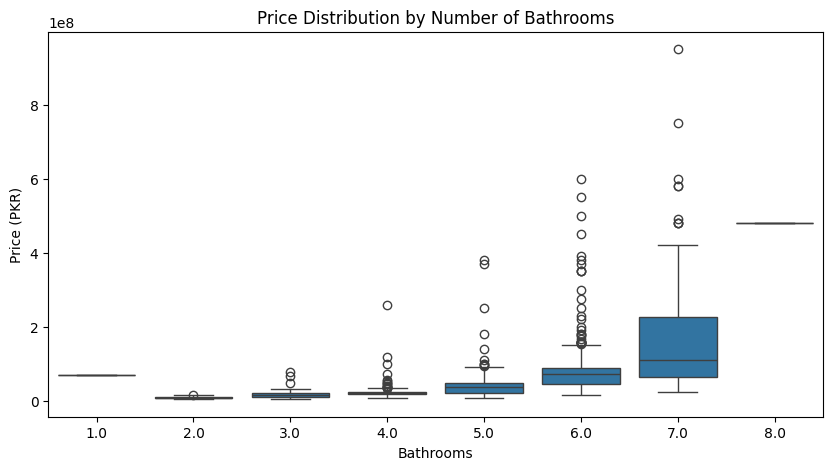

In [47]:
price_by_bathrooms = df.groupby('Bathrooms')['Price_PKR'].agg(['mean', 'median', 'min', 'max', 'count'])
print("\n=== Price by Number of Bathrooms ===")
print(price_by_bathrooms)

plt.figure(figsize=(10, 5))
sns.boxplot(x='Bathrooms', y='Price_PKR', data=df)
plt.title('Price Distribution by Number of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Price (PKR)')
plt.show()

Observations:

Like bedrooms, more bathrooms generally mean higher price.

Notice again the median is usually less than the mean, which suggests a few very expensive properties influence the average.

Sample sizes show that 4-6 bathrooms are the most common in this dataset.

Extremely high prices at 8 bathrooms might be outliers or luxury properties.


=== Top 10 Locations by Number of Listings ===
Primary_Location
DHA Phase 6                    86
DHA Phase 7                    83
Park View City                 78
DHA 9 Town                     56
DHA Phase 5                    43
Central Park Housing Scheme    32
DHA 11 Rahbar Phase 2          24
DHA Phase 8                    20
DHA Phase 4                    17
Wapda Town Phase 1             15
Name: count, dtype: int64


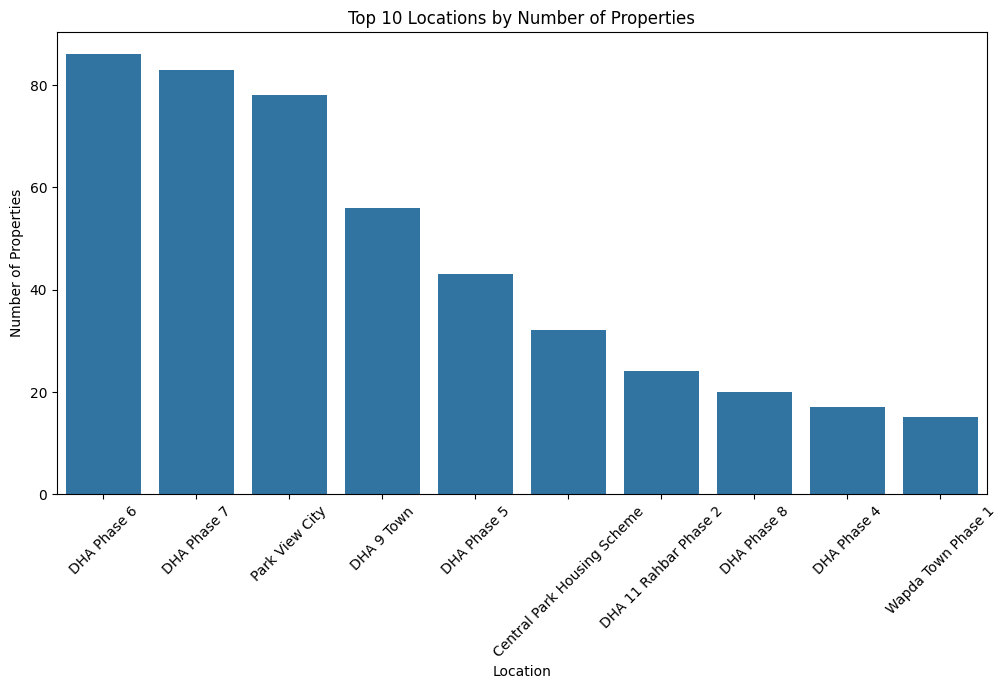

In [48]:
top_locations = df['Primary_Location'].value_counts().head(10)
print("\n=== Top 10 Locations by Number of Listings ===")
print(top_locations)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.xticks(rotation=45)
plt.title('Top 10 Locations by Number of Properties')
plt.xlabel('Location')
plt.ylabel('Number of Properties')
plt.show()

Observations:

DHA Phase 6 and DHA Phase 7 have the highest number of listings.

Most properties in the dataset are concentrated in DHA phases and nearby areas.

This tells us where the market activity or data coverage is strongest.


=== Average Price by Top 10 Locations ===
Primary_Location
DHA Phase 6                    1.471465e+08
DHA Phase 5                    1.119186e+08
DHA Phase 7                    8.082289e+07
DHA Phase 8                    7.048500e+07
DHA Phase 4                    6.752941e+07
Wapda Town Phase 1             4.940000e+07
Central Park Housing Scheme    2.800000e+07
DHA 9 Town                     2.446964e+07
DHA 11 Rahbar Phase 2          2.314583e+07
Park View City                 1.868077e+07
Name: Price_PKR, dtype: float64


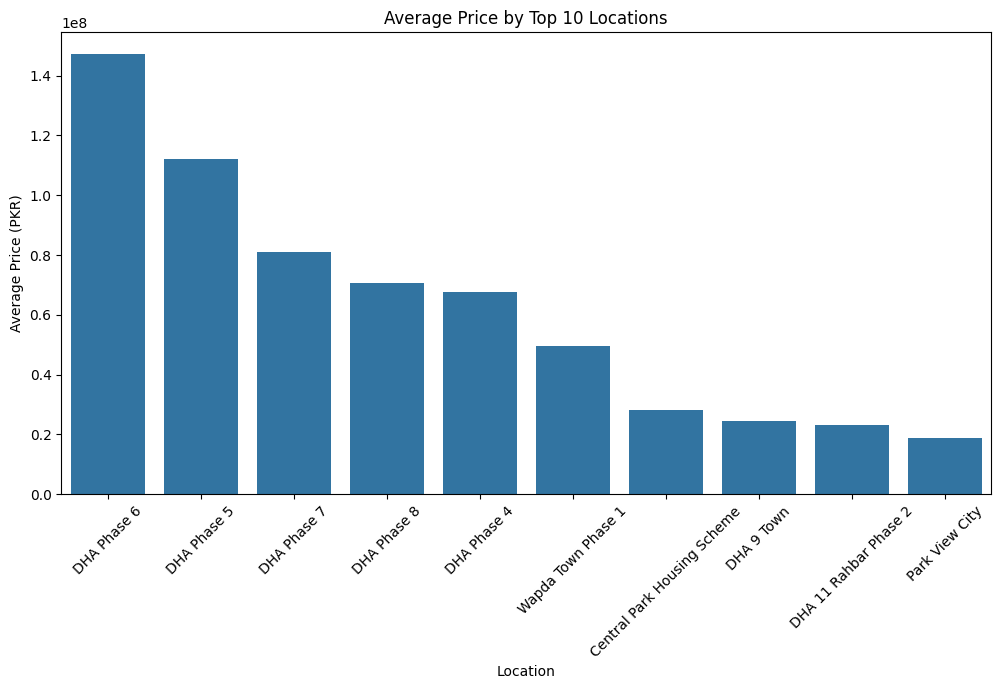

In [49]:
location_price_stats = df[df['Primary_Location'].isin(top_locations.index)].groupby('Primary_Location')['Price_PKR'].mean().sort_values(ascending=False)
print("\n=== Average Price by Top 10 Locations ===")
print(location_price_stats)

plt.figure(figsize=(12, 6))
sns.barplot(x=location_price_stats.index, y=location_price_stats.values)
plt.xticks(rotation=45)
plt.title('Average Price by Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Average Price (PKR)')
plt.show()

Observations:

DHA Phase 6 commands the highest average prices, nearly 1.5 crore PKR.

Park View City, despite having many listings, has one of the lowest average prices among these top locations.

Prices drop as we move away from the prime DHA phases.


=== Correlation Matrix ===
            Price_PKR  Bedrooms  Bathrooms  Area_Marla
Price_PKR    1.000000  0.525707   0.481860    0.846428
Bedrooms     0.525707  1.000000   0.855171    0.622018
Bathrooms    0.481860  0.855171   1.000000    0.588971
Area_Marla   0.846428  0.622018   0.588971    1.000000


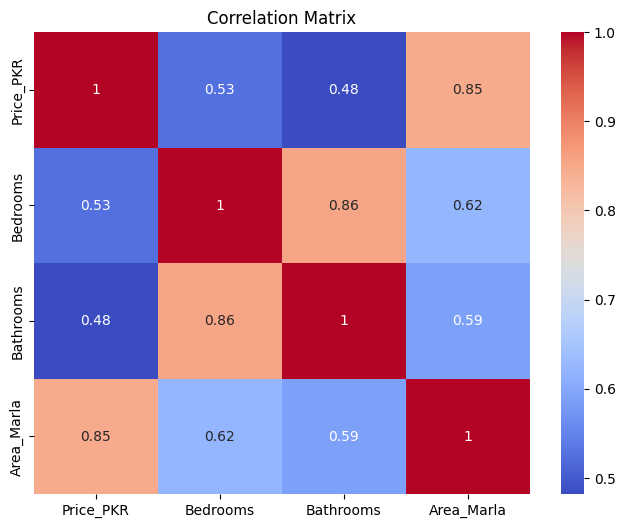

In [50]:
print("\n=== Correlation Matrix ===")
corr_matrix = df[['Price_PKR', 'Bedrooms', 'Bathrooms', 'Area_Marla']].corr()
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Observations:

Price correlates strongest with Area (0.85) — bigger area means higher price.

Bedrooms (0.53) and bathrooms (0.48) also correlate positively but less strongly.

Bedrooms and bathrooms are very strongly correlated (0.86), which means more bedrooms generally come with more bathrooms.

Area also moderately correlates with bedrooms and bathrooms.


=== Price per Marla Statistics ===
count    1.226000e+03
mean     4.457472e+06
std      1.642151e+06
min      8.000000e+05
25%      3.550000e+06
50%      4.100000e+06
75%      4.912500e+06
max      2.794118e+07
Name: Price_per_Marla, dtype: float64


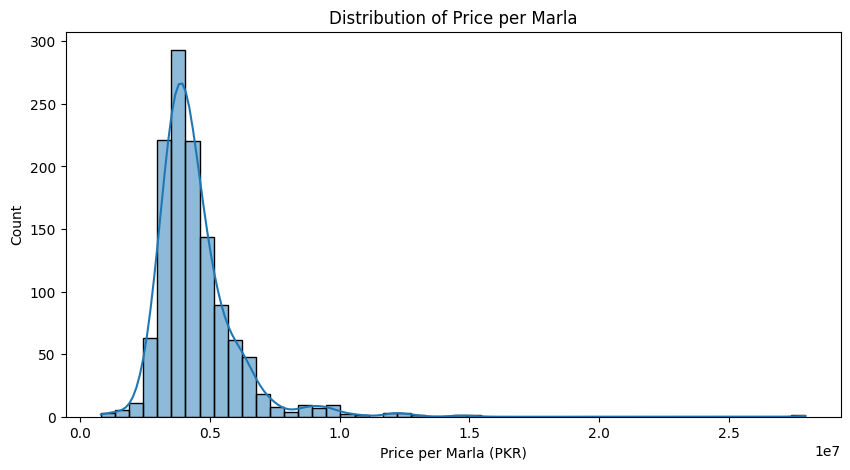

In [51]:
df['Price_per_Marla'] = df['Price_PKR'] / df['Area_Marla']
print("\n=== Price per Marla Statistics ===")
print(df['Price_per_Marla'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['Price_per_Marla'], bins=50, kde=True)
plt.title('Distribution of Price per Marla')
plt.xlabel('Price per Marla (PKR)')
plt.ylabel('Count')
plt.show()

Observations:

Average price per Marla is around 4.45 million PKR.

There is wide variation in price per Marla, suggesting some areas are far more expensive per unit area.

Median and quartiles show most properties fall between 3.55 million to 4.9 million PKR per Marla.

The maximum price per Marla is very high (almost 28 million PKR), indicating luxury or prime location properties.



**OVERALL SUMMARY OF PLOTS AND GRAPHS' OBSERVATIONS**

Summary:
Property size (area) strongly influences price.

More bedrooms and bathrooms usually mean a higher price, but area is a better predictor.

The market is concentrated in certain locations (mainly DHA phases).

Location hugely affects price per Marla — some locations are much pricier.

There are some very high-end properties that skew average prices upwards.

Bedroom and bathroom counts are related (homes with more bedrooms tend to have more bathrooms)

In [52]:
df.head()

,Title,Price,Location,Bedrooms,Bathrooms,Area,Price_PKR,Area_Marla,Primary_Location,Price_per_Marla
0,10 Marla House For Sale In Gulbahar Block Bahr...,3.2 Crore,"Bahria Town - Gulbahar Block, Bahria Town - Se...",5.0,6.0,10 Marla,32000000.0,10.0,Bahria Town - Gulbahar Block,3.200000e+06
1,5 Marla House For Sale In AA Block Bahria Town...,1.8 Crore,"Bahria Town - Block AA, Bahria Town - Sector D",3.0,4.0,5 Marla,18000000.0,5.0,Bahria Town - Block AA,3.600000e+06
2,Elegance Meets Functionality 1-Kanal Spanish T...,14.9 Crore,"DHA Phase 6 - Block C, DHA Phase 6",8.0,7.0,1 Kanal,149000000.0,20.0,DHA Phase 6 - Block C,7.450000e+06
3,Stunning 1-Kanal Designer Bungalow with Fully ...,12.99 Crore,"DHA Phase 6 - Block B, DHA Phase 6",6.0,7.0,1 Kanal,129900000.0,20.0,DHA Phase 6 - Block B,6.495000e+06
4,Brand New 13-Marla Corner House Facing Park | ...,7 Crore,"DHA Phase 4, DHA Defence",5.0,6.0,13 Marla,70000000.0,13.0,DHA Phase 4,5.384615e+06


In [53]:
df.shape

(1226, 10)

In [54]:
location_freq = df['Primary_Location'].value_counts(normalize=True)
df['Primary_Location_FreqEnc'] = df['Primary_Location'].map(location_freq)

In [55]:
print("\nSample of encoded Primary_Location:\n", df[['Primary_Location', 'Primary_Location_FreqEnc']].head())


Sample of encoded Primary_Location:
                Primary_Location  Primary_Location_FreqEnc
0  Bahria Town - Gulbahar Block                  0.000816
1        Bahria Town - Block AA                  0.003263
2         DHA Phase 6 - Block C                  0.004078
3         DHA Phase 6 - Block B                  0.004078
4                   DHA Phase 4                  0.013866


In [56]:
features = ['Bedrooms', 'Bathrooms', 'Area_Marla', 'Primary_Location_FreqEnc']
target = 'Price_PKR'

In [57]:
X = df[features]
y = df[target]

In [58]:
numeric_features = ['Bedrooms', 'Bathrooms', 'Area_Marla']
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X[numeric_features])
poly_feature_names = poly.get_feature_names_out(numeric_features)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X.index)

In [59]:
X_final = pd.concat([X_poly_df, X['Primary_Location_FreqEnc']], axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [61]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"{name} Performance:")
    print(f"  MAE: {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  R^2 Score: {r2:.4f}\n")

In [62]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": lgb.LGBMRegressor(random_state=42)
}

In [63]:
print("----- Model Evaluation Results -----\n")
for name, model in models.items():
    evaluate_model(name, model, X_train, y_train, X_test, y_test)

----- Model Evaluation Results -----

Random Forest Performance:
  MAE: 15,885,820.24
  RMSE: 41,131,754.09
  R^2 Score: 0.7874

CatBoost Performance:
  MAE: 17,055,733.12
  RMSE: 43,136,797.00
  R^2 Score: 0.7662

XGBoost Performance:
  MAE: 17,240,809.40
  RMSE: 44,040,100.38
  R^2 Score: 0.7563

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 10
[LightGBM] [Info] Start training from score 64798459.183673
LightGBM Performance:
  MAE: 16,001,641.21
  RMSE: 37,101,731.93
  R^2 Score: 0.8270



In [64]:
lgb_model = models['LightGBM']
lgb_model.fit(X_train, y_train)
importances = lgb_model.feature_importances_
feature_names = X_train.columns

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 10
[LightGBM] [Info] Start training from score 64798459.183673


In [65]:
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


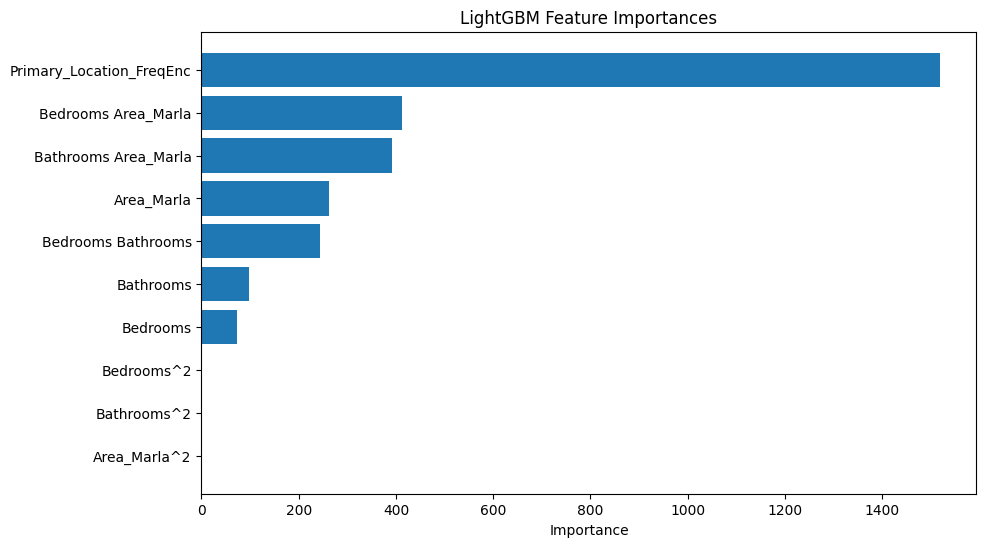

In [66]:
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('LightGBM Feature Importances')
plt.xlabel('Importance')
plt.show()

In [67]:
zero_importance_features = ['Bedrooms^2', 'Bathrooms^2', 'Area_Marla^2']
X_train_reduced = X_train.drop(columns=[col for col in zero_importance_features if col in X_train.columns])
X_test_reduced = X_test.drop(columns=[col for col in zero_importance_features if col in X_test.columns])


In [68]:
lgb_model_reduced = lgb.LGBMRegressor(random_state=42)
lgb_model_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = lgb_model_reduced.predict(X_test_reduced)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 7
[LightGBM] [Info] Start training from score 64798459.183673


In [69]:
print("\n----- LightGBM on Reduced Features -----")
evaluate_model("LightGBM (Reduced)", lgb_model_reduced, X_train_reduced, y_train, X_test_reduced, y_test)


----- LightGBM on Reduced Features -----
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 7
[LightGBM] [Info] Start training from score 64798459.183673
LightGBM (Reduced) Performance:
  MAE: 16,001,641.21
  RMSE: 37,101,731.93
  R^2 Score: 0.8270



In [70]:
print("\n----- Tuning LightGBM Hyperparameters -----")
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [20, 30, 40]
}


----- Tuning LightGBM Hyperparameters -----


In [71]:
grid_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_reduced, y_train)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 7
[LightGBM] [Info] Start training from score 64798459.183673


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [10, 20, 30],
                         'min_child_samples': [20, 30, 40],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 50, 70]},
             scoring='neg_mean_absolute_error', verbose=2)

In [72]:
print(f"\nBest Parameters: {grid_search.best_params_}")

# === Step 7: Evaluate Tuned LightGBM ===
best_lgb = grid_search.best_estimator_
best_lgb.fit(X_train_reduced, y_train)
y_pred_best = best_lgb.predict(X_test_reduced)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 20, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 7
[LightGBM] [Info] Start training from score 64798459.183673


In [73]:
print("\n----- Tuned LightGBM Final Evaluation -----")
evaluate_model("LightGBM (Tuned)", best_lgb, X_train_reduced, y_train, X_test_reduced, y_test)


----- Tuned LightGBM Final Evaluation -----
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 7
[LightGBM] [Info] Start training from score 64798459.183673
LightGBM (Tuned) Performance:
  MAE: 16,334,563.21
  RMSE: 37,986,052.46
  R^2 Score: 0.8187



In [74]:
sample_data = pd.DataFrame({
    'Bedrooms': [3, 5],
    'Bathrooms': [2, 4],
    'Area_Marla': [10, 20],
    'Primary_Location_FreqEnc': [0.12, 0.45]
})


In [75]:
sample_poly = poly.transform(sample_data[numeric_features])
sample_poly_df = pd.DataFrame(sample_poly, columns=poly_feature_names)

sample_final = pd.concat([sample_poly_df, sample_data['Primary_Location_FreqEnc']], axis=1)

for feat in zero_importance_features:
    if feat in sample_final.columns:
        sample_final.drop(columns=feat, inplace=True)


In [76]:
predicted_prices = best_lgb.predict(sample_final)

# Display
for i, price in enumerate(predicted_prices, start=1):
    print(f"Sample {i} - Predicted Price: PKR {price:,.0f}")


Sample 1 - Predicted Price: PKR 48,026,365
Sample 2 - Predicted Price: PKR 81,462,278


In [77]:
location_freq_map = df['Primary_Location'].value_counts(normalize=True).to_dict()


In [78]:
def predict_price(model, location, bedrooms, bathrooms, area_marla, freq_map):
    encoded_loc = freq_map.get(location, 0)

    data = pd.DataFrame([{
        'Bedrooms': bedrooms,
        'Bathrooms': bathrooms,
        'Area_Marla': area_marla,
        'Primary_Location_FreqEnc': encoded_loc
    }])

    poly = PolynomialFeatures(degree=2, include_bias=False)
    numeric_features = ['Bedrooms', 'Bathrooms', 'Area_Marla']
    poly_features = poly.fit_transform(data[numeric_features])
    poly_feature_names = poly.get_feature_names_out(numeric_features)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

    final_input = pd.concat([poly_df, pd.DataFrame({'Primary_Location_FreqEnc': [encoded_loc]})], axis=1)

    final_input = final_input.drop(columns=['Bedrooms^2', 'Bathrooms^2', 'Area_Marla^2'])

    prediction = model.predict(final_input)[0]
    print(f"Predicted Price: PKR {prediction:,.0f}")
    return prediction


In [79]:
predict_price(
    model=best_lgb,
    location="DHA Phase 1",
    bedrooms=5,
    bathrooms=7,
    area_marla=40,
    freq_map=location_freq_map
)


Predicted Price: PKR 242,804,735


np.float64(242804734.96149048)

In [80]:
import joblib
import os

os.makedirs("models", exist_ok=True)

joblib.dump(best_lgb, "models/best_lgb_model.pkl")

location_freq_encoding = df.groupby('Primary_Location').size() / len(df)
joblib.dump(location_freq_encoding.to_dict(), "models/location_freq_encoding.pkl")

print(" Model and preprocessors saved successfully in the 'models/' directory.")


 Model and preprocessors saved successfully in the 'models/' directory.
